# PINN Style Investigations

## First, PINN idea with 1 order of differentiation, so 4 terms including first strain derivative

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.append('../src')
from deepymod_torch.library_function import strain_input_library
from deepymod_torch.DeepMod import DeepMoD_PINN
from deepymod_torch.VE_params import coeffs_from_model_params, model_params_from_coeffs

/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

No thresholding is done in thsi investigation. DeepMoD_PINN simply takes the diff_order to already arrive at teh correct equation (wrong coeffs) from the offset, and then trains around that. No attempt is made to remove terms, it is just a search to model the data with a NN, and find the rigth coeffs.

Hoepfully it finds the correct coeffs

if not, I guess we will test to see if

- starting again always reproduces teh same constants

- if teh system has converged or is still converging.

- whether launching the training with the already trained NN to give it more time allows us to correct for the error.

In [2]:
Input_Type = 'Strain'
Input_Function = lambda time_data: torch.sin(time_data)/time_data

In [3]:
data = np.loadtxt('../data/StressStrain/Strain Sinc E[1, 10] V[20].csv', delimiter=',')
time_Array, strain_array, Stress_Array = data[:3000,0:1], data[:3000,1:2], data[:3000,2:]

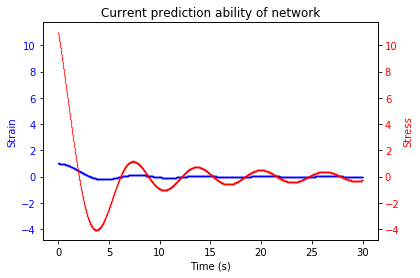

In [4]:
fig, ax1 = plt.subplots()
plt.title('Current prediction ability of network')
ax1.set_xlabel('Time (s)')
colour = 'blue'
ax1.set_ylabel('Strain', color=colour)
ax1.plot(time_Array, strain_array, color=colour, linestyle='None', marker='.', markersize=0.5)
ax1.tick_params(axis='y', labelcolor=colour)
ax2 = ax1.twinx()
colour = 'red'
ax2.set_ylabel('Stress', color=colour)
ax2.plot(time_Array, Stress_Array, color=colour, linestyle='None', marker='.', markersize=0.5)
ax2.tick_params(axis='y', labelcolor=colour)
ax1.set_ylim(ax2.get_ylim())
plt.show()

In [6]:
noise_level = 0.05
#noisy_stress_array = Stress_Array + noise_level * np.std(Stress_Array) * np.random.standard_normal(Stress_Array.shape)
noisy_stress_array = Stress_Array

In [7]:
number_of_samples = 1000

reordered_row_indices = np.random.permutation(time_Array.size)
reduced_time_array = time_Array[reordered_row_indices, :][:number_of_samples]
reduced_stress_array = noisy_stress_array[reordered_row_indices, :][:number_of_samples]

In [8]:
time_Tensor = torch.tensor(reduced_time_array, dtype=torch.float32, requires_grad=True)
Stress_Tensor = torch.tensor(reduced_stress_array, dtype=torch.float32)

no matter that lambda is unchanged, the function changes this itself to zero. This is already part of the default flow so i kept it in.

In [9]:
optim_config = {'lambda': 10**-5, 'max_iterations': 20001}

In [10]:
network_config = {'input_dim': 1, 'hidden_dim': 25, 'layers': 5, 'output_dim': 1}

`diff_order` crucially is now 1, so that we have actually fully defined the equation which is correct, we are only looking for the coeffs.

In [13]:
lib_config = {'type': strain_input_library, 'diff_order': 1, 'coeff_sign': 'positive', 'input_type': Input_Type, 'input_expr': Input_Function}

prediction of what we are aiming for

In [12]:
not_floats = coeffs_from_model_params([1, 10], [20])
[float(x) for x in not_floats]

[0.5, 0.55, 1.0]

Epoch | Total loss | MSE | PI | L1 
20000 5.5E-04 5.1E-04 4.0E-05 0.0E+00
tensor([[0.0636],
        [0.0466],
        [0.0894]], requires_grad=True)
lrs are 0.001 0.001
Total time elapsed: 15.0 minutes 23.775718927383423 seconds


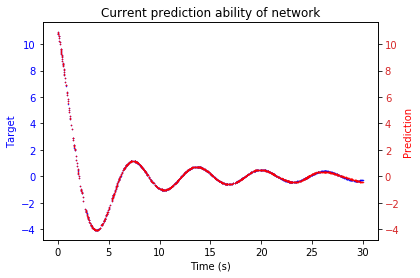

In [14]:
sparse_coeff_vector, sparsity_mask, network = DeepMoD_PINN(time_Tensor, Stress_Tensor, network_config, lib_config, optim_config)

In [21]:
Model_Params = model_params_from_coeffs(sparse_coeff_vector[0].detach())
Model_Params

([(11.1832683075793, 1.55559812101353, 24.4543416076316)], [E_0, E_1, eta_1])

In [18]:
import importlib
import deepymod_torch.DeepMod as DM

In [23]:
importlib.reload(DM)

<module 'deepymod_torch.DeepMod' from '/home/working/src/deepymod_torch/DeepMod.py'>

Epoch | Total loss | MSE | PI | L1 
20000 8.2E-05 7.9E-05 3.1E-06 0.0E+00
tensor([[0.0463],
        [0.0455],
        [0.0908]], requires_grad=True)
lrs are 0.001 0.001
Total time elapsed: 15.0 minutes 10.852928161621094 seconds


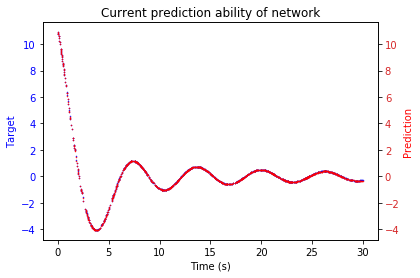

In [24]:
sparse_coeff_vector, sparsity_mask, network = DM.DeepMoD_PINN(time_Tensor, Stress_Tensor, network_config, lib_config, optim_config, NN=network, coeffs=(sparse_coeff_vector, sparsity_mask))

In [25]:
Model_Params = model_params_from_coeffs(sparse_coeff_vector[0].detach())
Model_Params

([(11.0100337213625, 1.11961087811237, 24.2073715463170)], [E_0, E_1, eta_1])

In [26]:
import sympy as sym

sys.path.append('../')
import data.Generation.VE_DataGen_Functions as vedg

In [27]:
Input_Type = 'Strain'
E = list(Model_Params[0][0][:2])
Eta = list(Model_Params[0][0][2:3])
t = sym.symbols('t', real=True)
Input_Function = sym.sinc(t)
Input_Description = 'Sinc'
Int_Type = 'Numerical'

In [28]:
Tuple_of_Expressions = vedg.Stress_Strain_Master_Int(Input_Type, E, Eta, Input_Function, Int_Type, t)
Tuple_of_Expressions

(11.0100337213625 + 1.11961087811237*exp(-0.0462508238852024*t),
 <function data.Generation.VE_DataGen_Functions.Stress_Strain_Master_Int.<locals>.<lambda>(t)>)

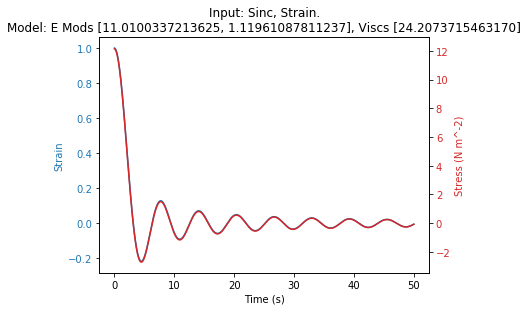

In [29]:
time = np.linspace(0.001, 50, 5000)

title = ('Input: ' + Input_Description + ', ' + Input_Type + 
         '.\nModel: E Mods ' + str(E) + ', Viscs ' + str(Eta))

result_strain_array, result_stress_array = vedg.Eval_Graph_Strain_Stress(title, time, Input_Function, Tuple_of_Expressions, Input_Type, Int_Type, t)

In [ ]:
plt.plot(time[:3000], result_stress_array[:3000], label='result')
plt.plot(time[:3000], Stress_Array, label='input')
plt.legend()

Unfortunately for my understanding, admittedly these two curves look very different! So I am not sure how deepmod could have confused them.....

In [ ]:
plt.plot(time[:3000], result_strain_array[:3000], label='result')
plt.plot(time[:3000], strain_array, label='input')
plt.legend()